# Mall Customer Segmentation and Forming Growth Strategy
by Kuanchieh Peng

## Dataset Overview
> The mall dataset contains information about customers such as customer_id, age, gender, annual income, and spending score.

## Problem Statement
> The goal is to increase customer lifetime value by segmenting customers into groups with similar characteristics and form growth strategies for each group.
## Background
> Given the competition of the retail market, it is essential to understand customer behavior and featues. This rule applies especially in targeted marketing, where understanding customers is a must to form effective marketing strategies. By creating customer segments, marketers can target specific groups of customers and with different marketing strategies such as promotions, pricing options, and product placement that catches the eye of the target audience in a cost-effective way.
## Sources
> Dataset used is "Mall_Customers" from https://www.kaggle.com/datasets/shwetabh123/mall-customers.
## Brief
- Preprocessing
- EDA
- Model and parameter selection
- Naming and plotting clustering results
- Forming growth stategies

## Imports

In [2]:
# for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# for modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold

# for evaluation
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import time

# for suppressing system warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)

In [3]:
df = pd.read_csv('mall_customers.csv')
original_df = df.copy()

## Pipeline

In [4]:
class bold:
    start = '\033[1m'
    end   = '\033[0m'

def information(df):
    # Prints typically useful statistical information about given dataframe.
    print("This dataframe consists of ", df.shape[1], " columns and", df.shape[0], " rows.")
    print("This dataframe consists of ", df.isnull().sum().sum(), " null entires.")
    print("This dataframe consists of ", df[df.duplicated()].shape[0], " duplicate rows.")
    print("")
    print(bold.start, "Notable statistics of numeric features in this dataset:", bold.end)
    print("")
    print(df.describe())
    print("")
    print(bold.start, "Object type of features in this dataset:", bold.end)
    print("")
    df.info()
    
def pca_results(n_components, data):
    sc = StandardScaler()
    X = sc.fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca
    
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
def roc(model_string, y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize = (9.6, 7.2))
    plt.grid()
    plt.plot(fpr, tpr, label = model_string + ' (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = "best")
    plt.show()

## Data Wrangling

In [5]:
df.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


#### Assessment Report

In [6]:
information(df)

This dataframe consists of  5  columns and 200  rows.
This dataframe consists of  0  null entires.
This dataframe consists of  0  duplicate rows.

 Notable statistics of numeric features in this dataset: 

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

 Object type of features in this dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data column

- There are no missing values in the dataframe.
- The feature CustomerID can be dropped as the indeces serve its purpose.
- The feature 'Gender' should be label encoded.
- Before performing PCA, drop gender (discrete instead of continuous) and standardize the data.

#### Label Encoding

In [7]:
df = original_df.copy()
df.drop(['CustomerID'], axis = 1, inplace = True)

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

In [8]:
df.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6


In [9]:
information(df)

This dataframe consists of  4  columns and 200  rows.
This dataframe consists of  0  null entires.
This dataframe consists of  0  duplicate rows.

 Notable statistics of numeric features in this dataset: 

           Gender         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean     0.440000   38.850000           60.560000               50.200000
std      0.497633   13.969007           26.264721               25.823522
min      0.000000   18.000000           15.000000                1.000000
25%      0.000000   28.750000           41.500000               34.750000
50%      0.000000   36.000000           61.500000               50.000000
75%      1.000000   49.000000           78.000000               73.000000
max      1.000000   70.000000          137.000000               99.000000

 Object type of features in this dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data column

## EDA
Calculate and visualize correlation between variables. Check for multicollineraity.

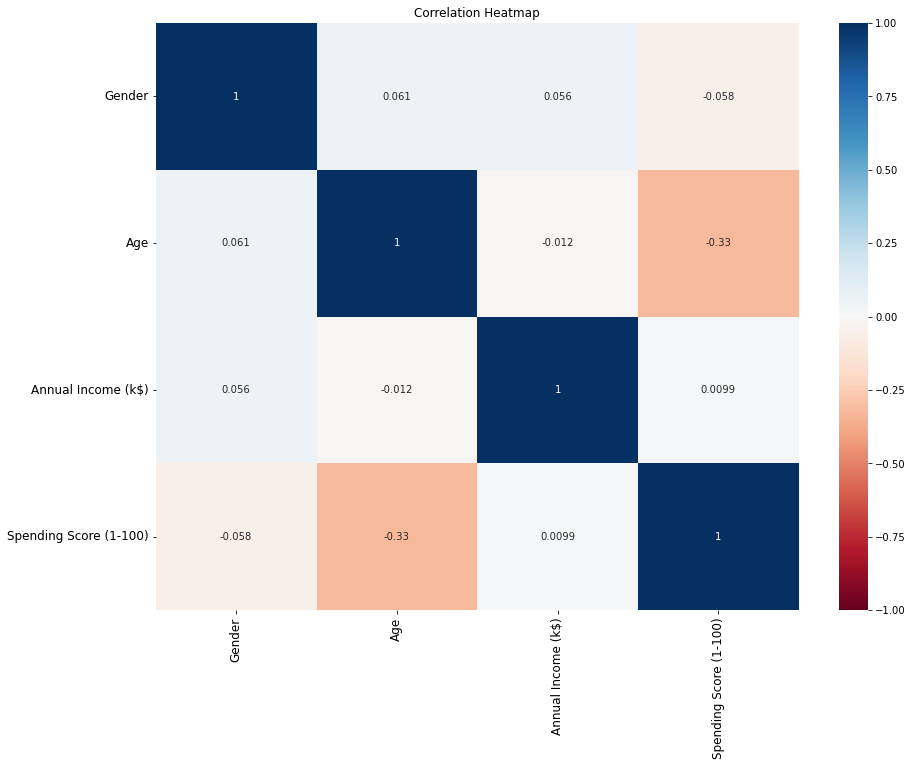

In [10]:
plt.figure(figsize = (14.4, 10.8))
plot1 = sns.heatmap(df.corr(), annot = True, cmap = 'RdBu', vmin = -1, vmax = 1, center = 0)
plot1.set_yticklabels(plot1.get_yticklabels(), rotation = 0, fontsize = 12)
plot1.set_xticklabels(plot1.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title("Correlation Heatmap")
plt.savefig("correlation.png",bbox_inches='tight')
plt.show()
#plot1.savefig('plot1.png', dpi = 400)

Age and spending score are the most correlated, with correlation coefficient -0.33.

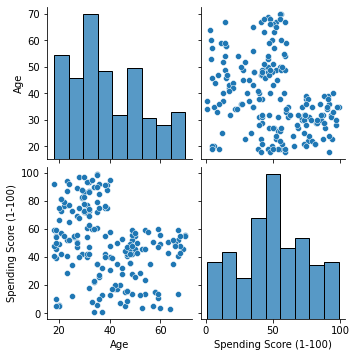

In [11]:
plot2 = sns.pairplot(df[['Age', 'Spending Score (1-100)']])
#plot2.savefig('plot2.png', dpi = 400)

#### Principal Component Analysis
Drop feature 'Gender' since PCA is designed for continuous variables. Then conduct PCA for distribution in 2D to discover potential clusters.

In [12]:
df_before_pca = df.copy()
df.drop(['Gender'], axis = 1, inplace = True)

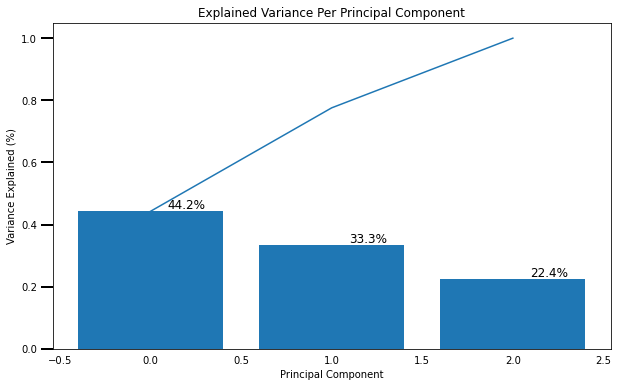

In [13]:
sc = StandardScaler()
df_transformed = sc.fit_transform(df)

pca, X_pca = pca_results(3, df_transformed)
scree_plot(pca)

According to the above, if we plot the distribution with PC1 and PC2, we only capture around 77.5% variance of the data.

Text(0, 0.5, 'component 2')

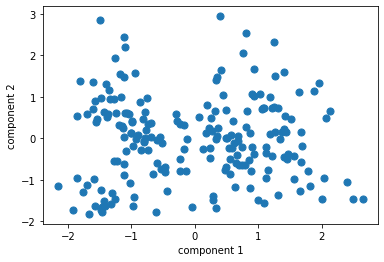

In [14]:
pca, X_pca = pca_results(2, df_transformed)
plt.scatter(X_pca[:,0], X_pca[:, 1], s = 50)
plt.xlabel('component 1')
plt.ylabel('component 2')

The number of clusters can hardly be told. There seems to be four clusters distributed in a slightly uneven matter.

#### Clustering Analysis

C:\Users\taan7\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


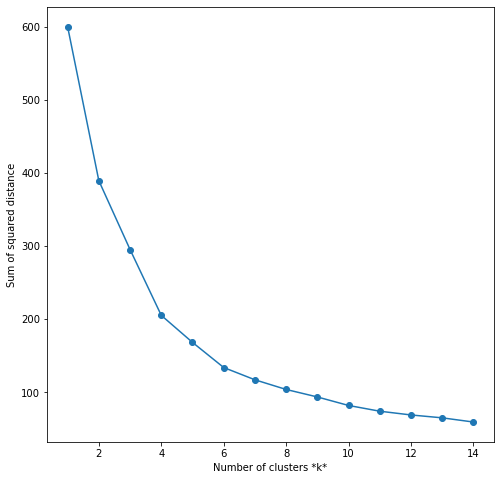

In [15]:
# using Elbow Method 

# Run the Kmeans algorithm and get the index of data points clusters
from sklearn.cluster import KMeans
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_transformed)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.savefig("elbow.png",bbox_inches='tight')

There is no clear elbow, a certain point where the amount of information added diminishes. Try Silhouette index to find optimal k.

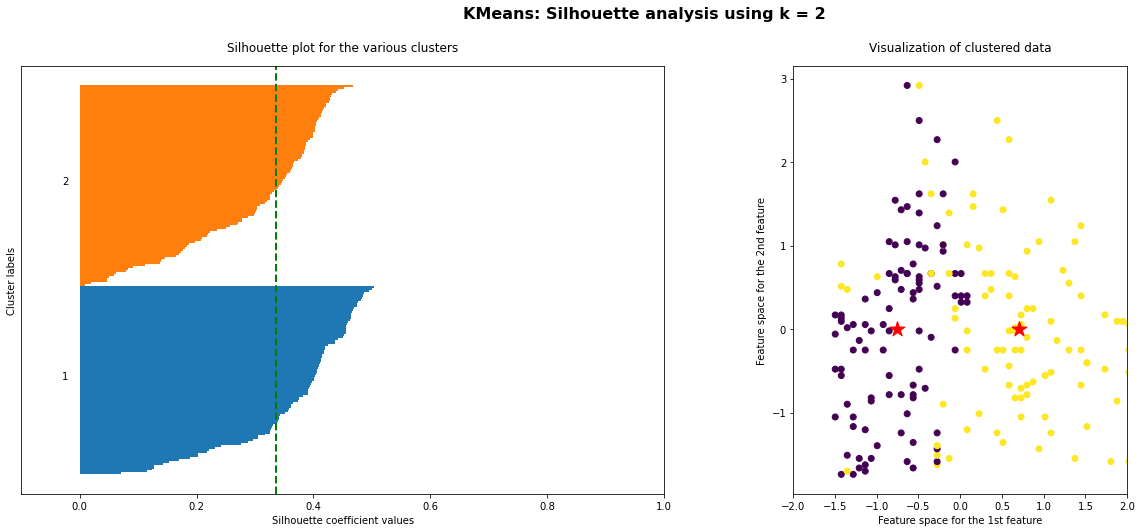

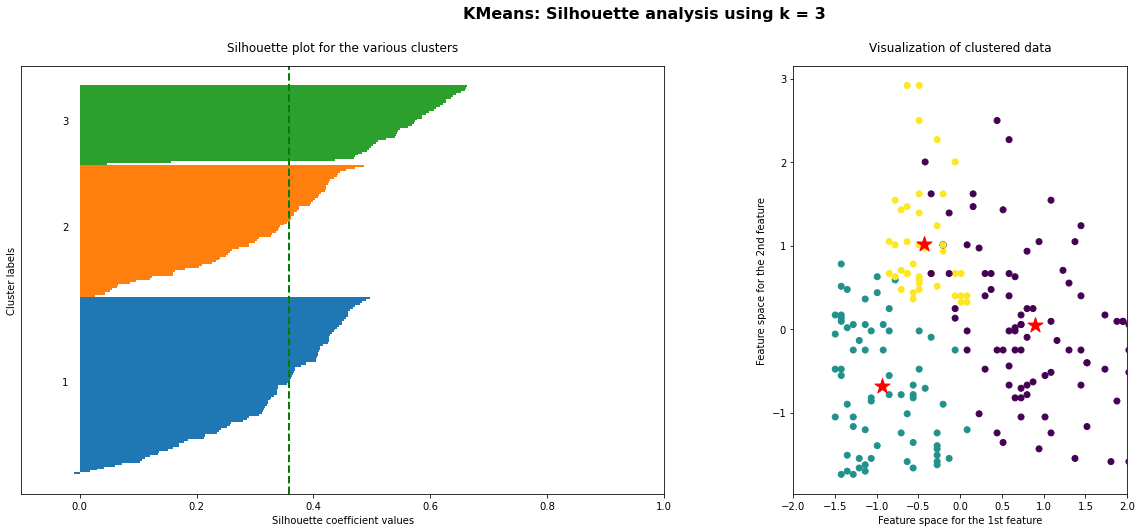

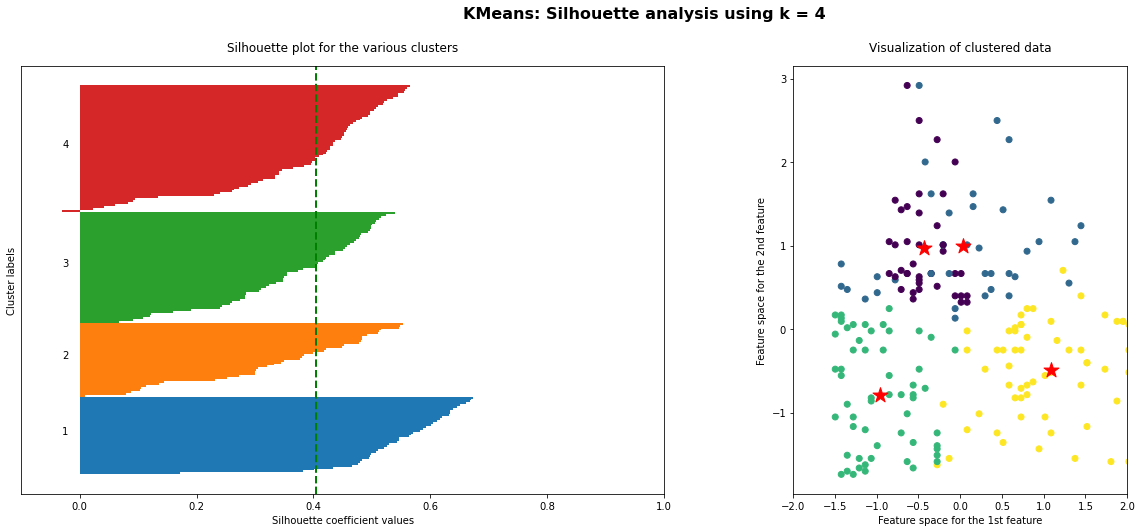

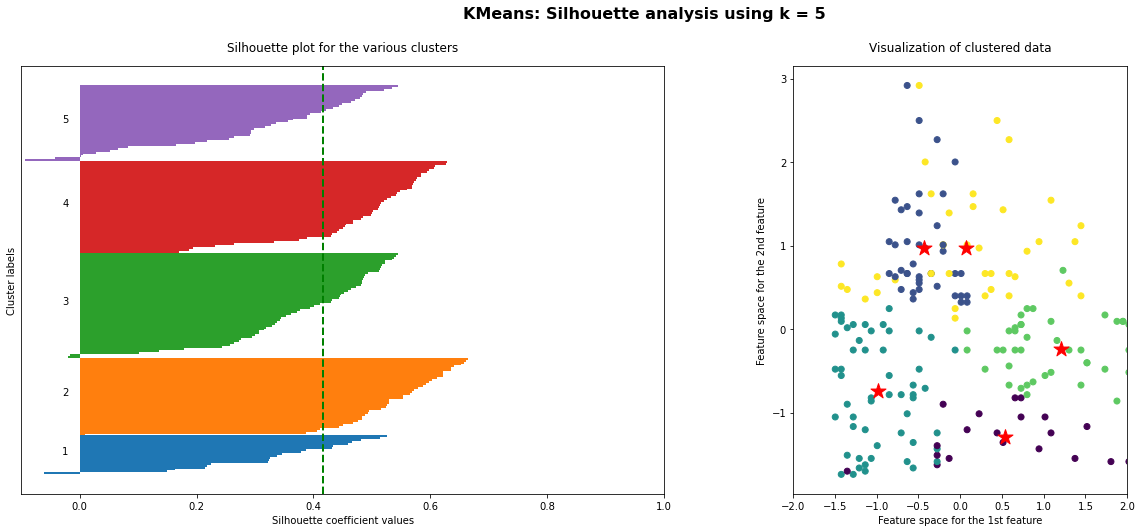

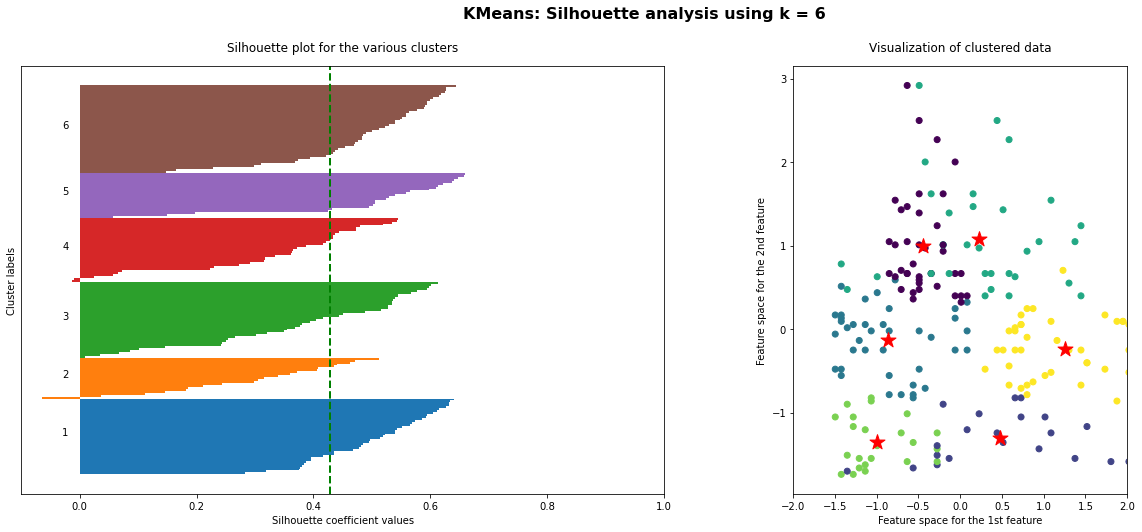

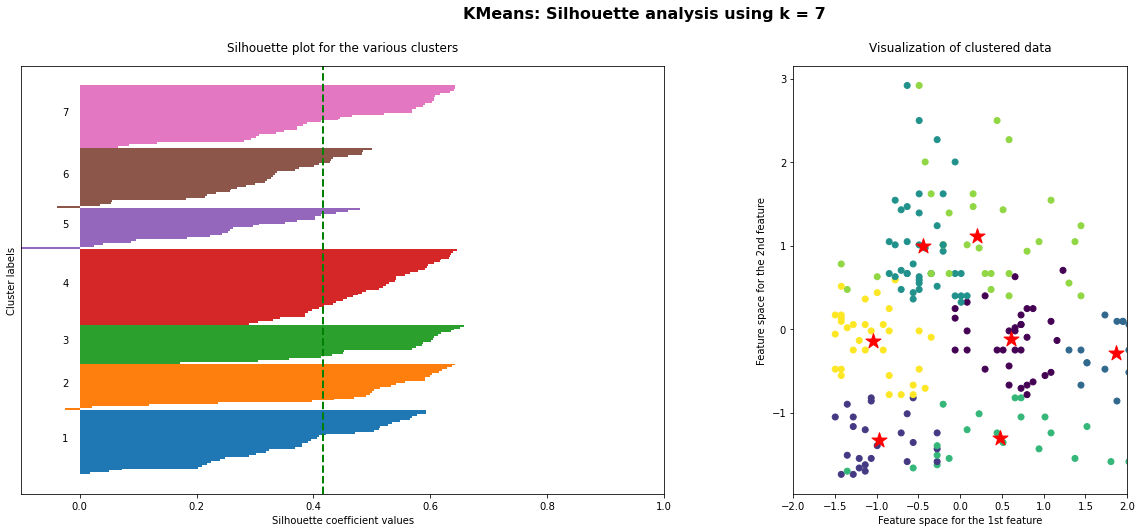

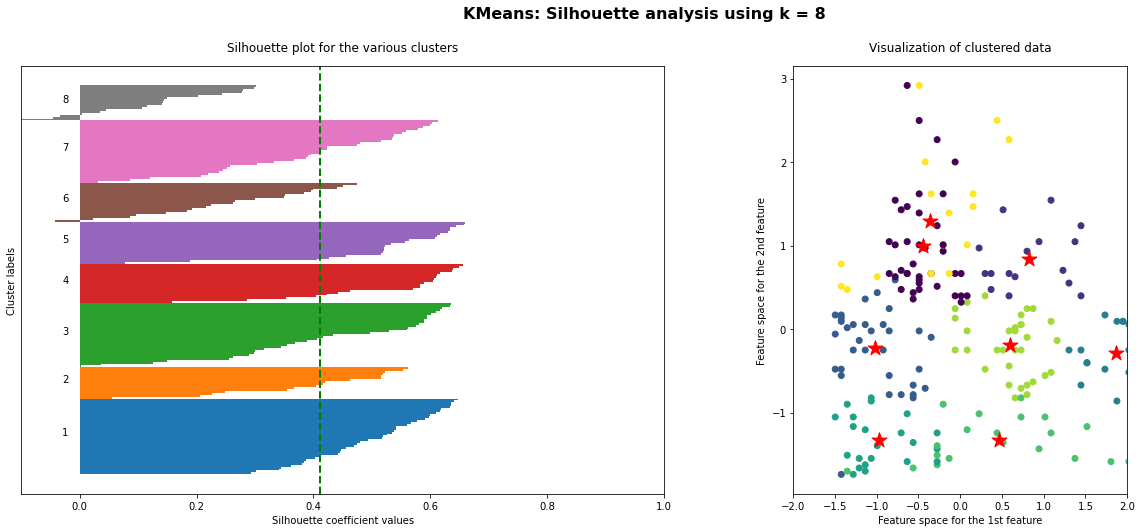

In [16]:
# Silhouette index method
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4, 5, 6, 7, 8]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(df_transformed)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(df_transformed, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(df_transformed[:, 0], df_transformed[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'KMeans: Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

k = 6 results in the highest average Silhouette score at approximately 0.42.
**Therefore, adopt k = 6 for KMeans.**

## Modeling
Model selection: Compare KMeans, Hierarchical Clustering and GMMs.

          KM        HC      GMMs   k
0   0.335472  0.317957  0.249660   2
1   0.357793  0.321489  0.340558   3
2   0.403958  0.361451  0.264121   4
3   0.416643  0.390028  0.406367   5
4   0.426855  0.420117  0.376684   6
5   0.415945  0.398295  0.388390   7
6   0.407537  0.366479  0.357413   8
7   0.395494  0.375385  0.362865   9
8   0.424429  0.380889  0.354228  10
9   0.411225  0.381198  0.325340  11
10  0.395580  0.353572  0.317608  12
11  0.371936  0.355790  0.287257  13
12  0.375664  0.353230  0.300182  14
13  0.366444  0.345435  0.323993  15


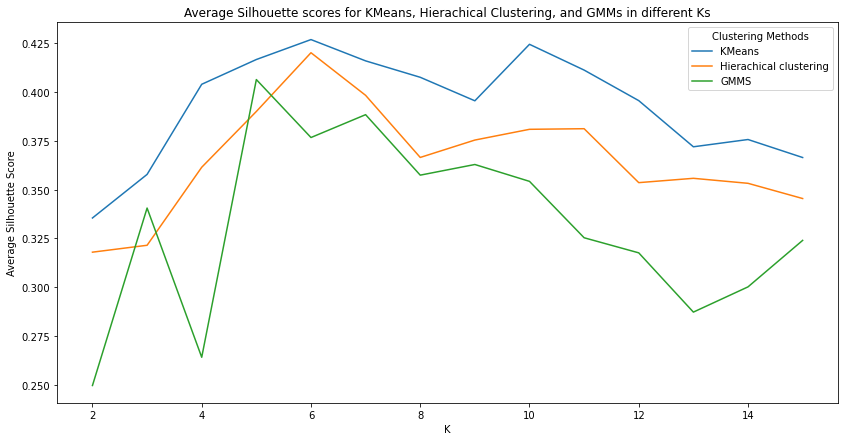

In [17]:
def plot_km_hc_gmms_in_different_ks(df_transformed, start_k, end_k):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.mixture import GaussianMixture
    
    avg_silhouette_scores = []

    for k in range(start_k, end_k+1):

        # Run the KMeans algorithm
        km = KMeans(n_clusters=k)
        km_labels = km.fit_predict(df_transformed)

        # Run the Hierachical clustering algorithm
        hc = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(df_transformed)
        hc_labels = hc.labels_

        # Run the GMMs algorithm
        gm = GaussianMixture(covariance_type="spherical", n_components=k, random_state=0).fit(df_transformed)
        gm_labels = GaussianMixture(n_components=k, random_state=0).fit_predict(df_transformed)

        # calculate average silhouette scores
        km_silhouette_vals = silhouette_samples(df_transformed, km_labels)
        hc_silhouette_vals = silhouette_samples(df_transformed, hc_labels)
        gm_silhouette_vals = silhouette_samples(df_transformed, gm_labels)
        km_avg_score = np.mean(km_silhouette_vals)
        hc_avg_score = np.mean(hc_silhouette_vals)
        gm_avg_score = np.mean(gm_silhouette_vals)
        avg_silhouette_scores.append([km_avg_score, hc_avg_score, gm_avg_score])

    df_avg_silhouette_scores = pd.DataFrame(avg_silhouette_scores, columns = ['KM', 'HC', "GMMs"])
    df_avg_silhouette_scores["k"] = range(start_k, end_k+1)
    print(df_avg_silhouette_scores)
    
    # plot male and female left-handedness rates vs. age
    fig, ax = plt.subplots() # create figure and axis objects
    fig.set_size_inches(14, 7)
    ax.set_title('Average Silhouette scores for KMeans, Hierachical Clustering, and GMMs in different Ks')
    ax.plot('k', 'KM', data=df_avg_silhouette_scores) 
    ax.plot('k', 'HC', data=df_avg_silhouette_scores) 
    ax.plot('k', 'GMMs', data=df_avg_silhouette_scores) 
    ax.legend(['KMeans',"Hierachical clustering", "GMMS"], title="Clustering Methods") # add a legend
    ax.set_xlabel('K')
    ax.set_ylabel("Average Silhouette Score");
    
plot_km_hc_gmms_in_different_ks(df_transformed, 2, 15)

- KMeans performs best when K = 6 with average Silhouette score ~= 0.425.
    - KMeans is the best performer with all K candidates.
- Hierarchical clustering performs best when K = 6 with average score ~= 0.420.
- GMMs perform best when K = 5 with average score ~= 0.400

**Conclusion of model selection: KMeans with K = 6.**

#### Analyzing Clustering Results

In [18]:
km = KMeans(n_clusters=6)
labels = km.fit_predict(df_transformed)

# reload data since we might want to use our customerID later
df = pd.read_csv('Mall_Customers.csv')
df['kmeans_label'] = labels

In [19]:
# calculate descriptive summaries
summary = df.groupby("kmeans_label")[['Age', 'Spending Score (1-100)']].mean()
summary['Median Annual Income(k)'] = df.groupby("kmeans_label")[['Annual Income (k$)']].median()
summary['Cnt'] = df.groupby('kmeans_label').CustomerID.count().values
summary['Male Cnt'] = df[df.Gender=="Male"].groupby("kmeans_label").CustomerID.count().values
summary['Female Cnt'] = df[df.Gender=="Female"].groupby("kmeans_label").CustomerID.count().values
summary['Male%'] = summary['Male Cnt']/summary['Cnt']
summary['Female%'] = summary['Female Cnt']/summary['Cnt']
summary.rename(columns={'Age':'Avg Age', "Spending Score (1-100)":'Avg Spending Score'}, inplace=True)

final_summary = summary[['Avg Age','Avg Spending Score',"Median Annual Income(k)","Cnt","Male%","Female%"]].sort_values(by='Avg Spending Score', ascending=False)
final_summary

,Avg Age,Avg Spending Score,Median Annual Income(k),Cnt,Male%,Female%
kmeans_label,,,,,,
2,32.692308,82.128205,79.0,39,0.461538,0.538462
4,25.250000,76.916667,24.5,24,0.416667,0.583333
1,56.333333,49.066667,54.0,45,0.422222,0.577778
3,26.684211,47.789474,60.0,38,0.368421,0.631579
5,45.523810,19.380952,25.0,21,0.380952,0.619048
0,41.939394,16.969697,86.0,33,0.575758,0.424242


Naming Each Cluster:
- High income, high spending, young
- Low income, high spending, young
- Mid income, mid spending, old
- Mid income, mid spending, young
- Low income, low spending, middle aged
- High income, low spending, middle aged

In [20]:
temp = final_summary

# convert index to a column and then rename each group
temp["group"] = [
    'High income, high spending, young', 
    'Low income, high spending, young',
    'Mid income, mid spending, old',
    'Mid income, mid spending, young',
    'Low income, low spending, middle aged',
    'High income, low spending, middle aged'
]
temp[['Male%']] = temp[['Male%']]*100
temp[['Female%']] = temp[['Female%']]*100
temp = temp.reindex(columns = [
    'group', 'Avg Age', 'Avg Spending Score', 'Male%', 'Female%', 
    'Median Annual Income(k)','Cnt'
])
temp

,group,Avg Age,Avg Spending Score,Male%,Female%,Median Annual Income(k),Cnt
kmeans_label,,,,,,,
2,"High income, high spending, young",32.692308,82.128205,46.153846,53.846154,79.0,39
4,"Low income, high spending, young",25.250000,76.916667,41.666667,58.333333,24.5,24
1,"Mid income, mid spending, old",56.333333,49.066667,42.222222,57.777778,54.0,45
3,"Mid income, mid spending, young",26.684211,47.789474,36.842105,63.157895,60.0,38
5,"Low income, low spending, middle aged",45.523810,19.380952,38.095238,61.904762,25.0,21
0,"High income, low spending, middle aged",41.939394,16.969697,57.575758,42.424242,86.0,33


#### Visualization: Radar Charts

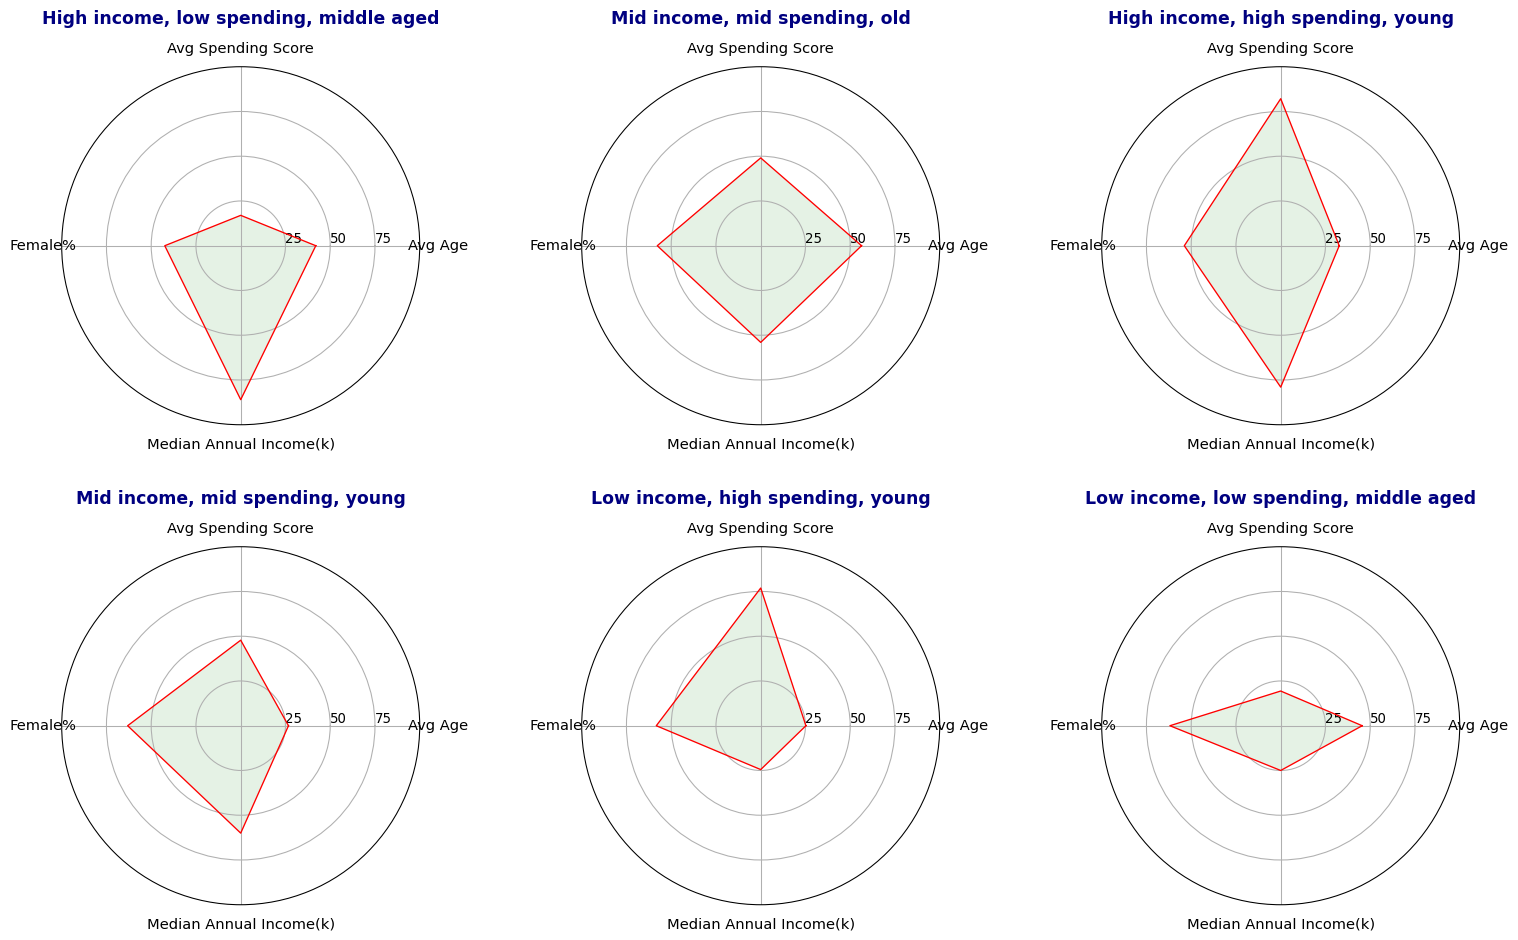

In [21]:
# create radar charts
def plot_radar(df, columns, row):
    # Libraries
    from math import pi
    N = len(columns)
    columns_no_need = df[df.columns.difference(columns)]

    # But we need to repeat the first value to close the circular graph:
    values=df.loc[row].drop(columns_no_need).values.flatten().tolist()
    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    #plt.subplots_adjust(left=None, bottom=None, right=None, top=0.5, wspace=None, hspace=None)
    # Initialise the spider plot

    ax = plt.subplot(2, 3, row+1, polar=True) 

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], columns, size=11)
    plt.title(df.loc[row].group, size=13, y=1.1,fontweight="bold",  color='navy')
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], 
               ["25","50","75"], size=10)
    plt.ylim(0,100)

    # Plot data
    ax.plot(angles, values, linewidth=1, color='r', linestyle='solid')
    # Fill area
    ax.fill(angles, values, 'g', alpha=0.1)


my_dpi=96
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)

# number of variable
columns=['Avg Age', 'Avg Spending Score', 'Female%', 'Median Annual Income(k)']
for i in range(0,6): 
    plot_radar(temp, columns, i)
plt.tight_layout(pad=3.0)

## Forming Growth Strategies

The following are common growth tactics for increasing customer lifetime value that can be applied to a mall business (mid-size b2c business).
- New customer programs
- Loyalty programs
- Upselling
- Referral programs
- Incentive program for ready-to-churn customers
- Incentive program for winning back lost customers

Analyze and apply strategies to the six groups. Groups are sorted by average spending score.
Groups:
- High income, high spending, young
- Low income, high spending, young
- Mid income, mid spending, old
- Mid income, mid spending, young
- Low income, low spending, middle aged
- High income, low spending, middle aged

### Group 1 (Most desirable legion!):  
### High Income,  High Spending, Young

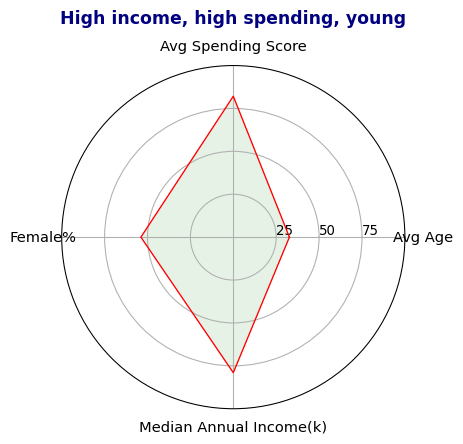

In [25]:
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)
plot_radar(temp, columns, 2)

They are young customers who earn lots and spend lots. There is hardly any more ideal target audience than these people, so we simply have to keep them. Therefore, **retention/loyalty is significantly important here**. 

Also, take advantage of their cicle, which likely also has high spending power.

*Recommended growth strategies:*
1. Loyalty program
2. Referral program
3. Upselling

### Group 2: Low Income, High Spending, Young

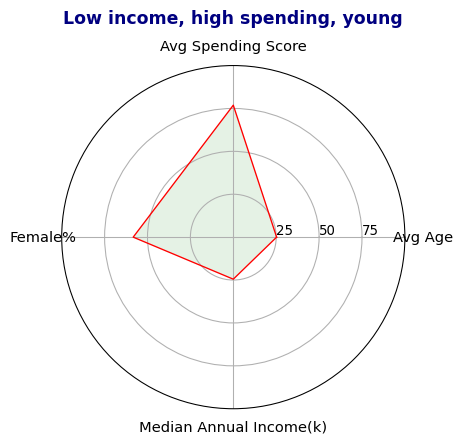

In [26]:
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)
plot_radar(temp, columns, 4)

They are young customers who earn less but somehow spend a lot at our mall. The impetus of this phenomenon is intriguing and is worth exploring. Some intuitive guesses are: locaional dependency, the fact that our mall renders brands/products they favor.


As they spend much, and assuming they can maintain such spending power, we want to keep them (retention/royalty program). As they earn less, a discount would likely be attractive (referral program). Another reason for the referral program is young people tend to have an active social circle.

*Recommended growth strategies:*
1. Loyalty program
2. Referral program

### Group 3: Mid Income, Mid Spending, Mid-Aged

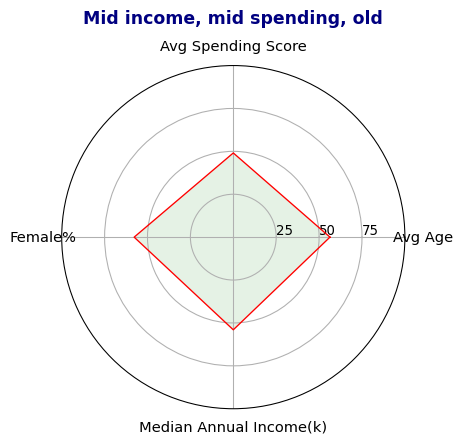

In [27]:
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)
plot_radar(temp, columns, 1)

They are middle-aged who earns and spends at the medium. Normally promotion frequencies drop off after the age of 30, therefore we infer that these customers don't have much growth potential in income and spending power. However, normally they are already at a financially stable state. Put them under our loyalty program until we have more information.

*Recommended growth strategies:*
1. Loyalty program 

### Group 4:  Mid Income, Mid Spending, Young

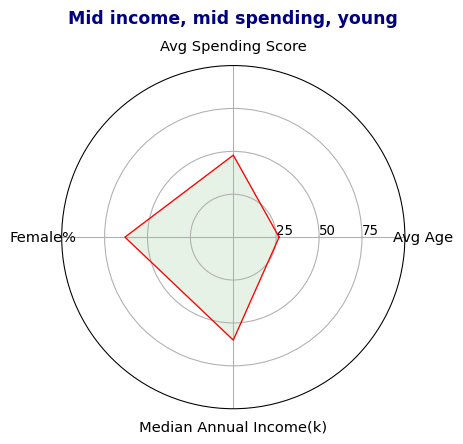

In [28]:
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)
plot_radar(temp, columns, 3)

The attributes are similar to that of the previous one, except this one has a much lower average age and a larger portion of women at approx. 60%. Put them under a loyalty program that is tailored for young female customers.

*Recommended growth strategies:*
1. Loyalty program

### Group 5: Low Income, Low Spending, Mid-aged

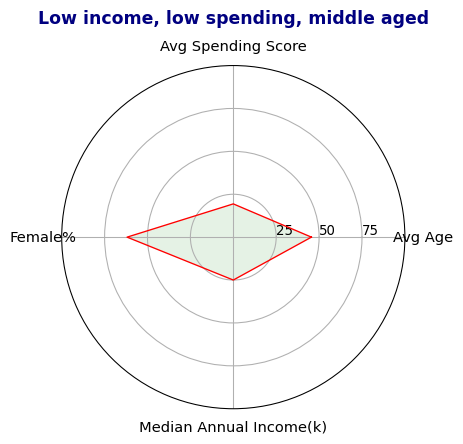

In [32]:
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)
plot_radar(temp, columns, 5)

They are middle-aged who spend and earn little. They are the least desirable group as they are old (limited spending growth potential and circle) and show little spending score. One thing we can do is to explore the circle they already have, on the hypothesis that they are rewards/discounts might spark more interest in spending.

Can we somehow convert some of them to group 2? 

*Recommended growth strategies:*
1. Referral 
2. TBD

### Group 6 (best potential): 
### High Income, Low Spending, Mid-aged

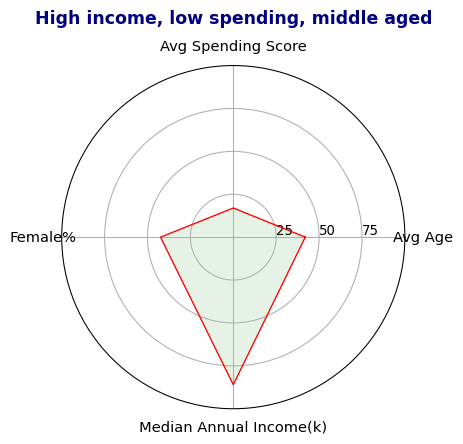

In [33]:
plt.figure(figsize=(1600/my_dpi, 1000/my_dpi), dpi=my_dpi)
plot_radar(temp, columns, 0)

They are middle aged (~60% men) who earn at approx. the 90th percentile but spend little. They have huge potential as in their spending score and their circle.

The question is, how do we turn as many of them into group 1 customers?

My hypotheses of their behavior are:
- Not interested in our counters/products
    - Do they shop at more high-end counters? 
- Not familiar with our counters/products
    - Is there any product they might be interested in but never knew we had?
- They are lost customers
    - Can we discover why they churned & win them back?
    
*Recommended growth strategies:*
1. Upselling 
2. New-custuomer program
3. Incentive program for winning back lost customers